# Backward Differentiation Formula


In [1]:
using Pkg
Pkg.activate(".")
using SymPy
using Plots

  Activating project at `c:\Users\tim\Documents\2025FallExamples\10-27`


Now let's make up some variables in a similar way to the Adams Methods

In [2]:
x1, x2, x3, x4, x5, x6, x7, x8 = symbols("x1, x2, x3, x4, x5, x6, x7, x8")
t1, t2, t3, t4, t5, t6, t7, t8 = symbols("t1, t2, t3, t4, t5, t6, t7, t8")
t = symbols("t")
X = [x1,x2,x3,x4,x5,x6,x7,x8]
T = [t1,t2,t3,t4,t5,t6,t7,t8]
f = symbols("f")
h = symbols("h")

function l(t,j,k)
    l = 1
    for m in 1:k
        if m != j
            l *= ( t - T[m] )/( T[j] - T[m] )
        end        
    end
    return l
end
;

This time we interpolate the $x$ values, instead of the $f(x)$ values.  Then
$$ x(t) \approx p(t) =  \sum_{j=0}^{k} x_j \ell_j(t)$$
So $\dot x \approx \frac{d p}{dt} $, where we simply differentiate $p$ as
$$ \frac{dp}{dt}  = \sum_{j=0}^{k} x_j \frac{d \ell_j(t)}{dt} $$
Putting this back into the differential equation
$$ \dot x = f(x) $$
gives the discrete equation for the next time step

$$ \left.\frac{dp}{dt}\right|_{t_{i+1}} = f(x_{i+1}) $$


In [3]:
n = 3
P = [ X[i]*l(t, i, n) for i in 1:n ] |> sum

x1*(t - t2)*(t - t3)   x2*(t - t1)*(t - t3)   x3*(t - t1)*(t - t2) 
-------------------- + -------------------- + ---------------------
(t1 - t2)*(t1 - t3)    (-t1 + t2)*(t2 - t3)   (-t1 + t3)*(-t2 + t3)

In [4]:
dP = diff(P,t)

    x1*(t - t2)           x1*(t - t3)           x2*(t - t1)            x2*(t - >
------------------- + ------------------- + -------------------- + ----------- >
(t1 - t2)*(t1 - t3)   (t1 - t2)*(t1 - t3)   (-t1 + t2)*(t2 - t3)   (-t1 + t2)* >

>  t3)             x3*(t - t1)             x3*(t - t2)     
> --------- + --------------------- + ---------------------
> (t2 - t3)   (-t1 + t3)*(-t2 + t3)   (-t1 + t3)*(-t2 + t3)

Again, let's assume that the time step is constant $h$

In [5]:
dP1 = dP |> subs(t=>T[n]) |>  subs(t2=>t1+h, t3=>t1+2*h, t4=>t1+3*h, t5=>t1+4*h, t6=>t1+5*h, t7=>t1+6*h, t8=>t1+7*h) |> simplify

x1 - 4*x2 + 3*x3
----------------
      2*h       

Now we can put this discrete approximation of the derivative back into the differential equation (where the $f = f(x_{i+1},t_{i+1})= f(x_3,t_3)$ 

In [6]:
eq = Eq( dP1, f)

x1 - 4*x2 + 3*x3    
---------------- = f
      2*h           

Lastly we can solve this system for $x_3$

In [7]:
solve(eq, X[n] )[1]

2*f*h   x1   4*x2
----- - -- + ----
  3     3     3  

This gives the right-hand-side of the classic BDF2 formula

In [8]:
Eq( x3, solve(eq, X[n] )[1] )

     2*f*h   x1   4*x2
x3 = ----- - -- + ----
       3     3     3  

## variable time step
Now I'm going to work with the variable step size methods for example

In [9]:
n = 3+1
P = [ X[i]*l(t, i, n) for i in 1:n ] |> sum
dP = diff(P,t) |> subs(t=>T[n])
coeffList = [diff(dP, x) |> simplify for x in X[1:n] ]

4-element Vector{Sym{PyCall.PyObject}}:
  (t2 - t4)*(t3 - t4)/((t1 - t2)*(t1 - t3)*(t1 - t4))
 -(t1 - t4)*(t3 - t4)/((t1 - t2)*(t2 - t3)*(t2 - t4))
  (t1 - t4)*(t2 - t4)/((t1 - t3)*(t2 - t3)*(t3 - t4))
             -1/(t3 - t4) - 1/(t2 - t4) - 1/(t1 - t4)

In [10]:
h, h1, h0 = symbols("h h_1 h_0", real=true)
# h= t4 - t3; h1 = t3 - t2; h0 = t2 - t1
hterms = [c |> subs( t4=> h + t3 ) |> subs( t3=> h1 + t2 ) |> subs( t2=> h0 + t1 ) |> expand |> simplify for c in coeffList ]

4-element Vector{Sym{PyCall.PyObject}}:
 h*(-h - h_1)/(h_0*(h*h_0 + h*h_1 + h_0^2 + 2*h_0*h_1 + h_1^2))
                          h*(h + h_0 + h_1)/(h_0*h_1*(h + h_1))
 (-h^2 - h*h_0 - 2*h*h_1 - h_0*h_1 - h_1^2)/(h*h_1*(h_0 + h_1))
                          1/(h + h_0 + h_1) + 1/(h + h_1) + 1/h

In [11]:
sympy.julia_code( hterms[1] ) |> println

h .* (-h - h_1) ./ (h_0 .* (h .* h_0 + h .* h_1 + h_0 .^ 2 + 2 * h_0 .* h_1 + h_1 .^ 2))


## Stability
Let's look at the stability of BDF3

In [12]:
σ, ω, θ, z = symbols("sigma omega theta z", real=true)

(sigma, omega, theta, z)

In [13]:
Z = (z^2 - 4*z + 3)/2 |> subs(z=>exp(1im*θ))

 2*I*theta                 
e               I*theta   3
---------- - 2*e        + -
    2                     2

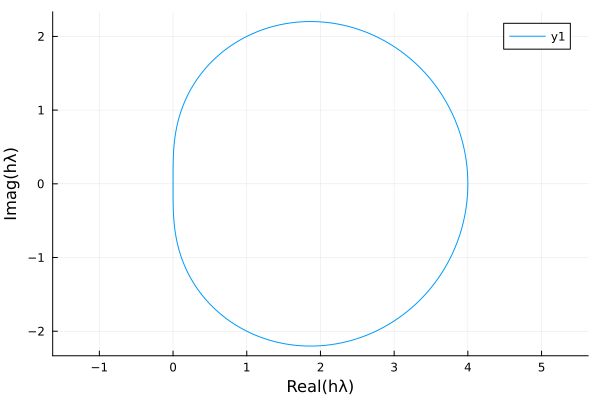

In [14]:
plot( real(Z), imag(Z), 0, 2π, xlabel="Real(hλ)", ylabel="Imag(hλ)", aspect_ratio=:equal)

Now let's do BDF5

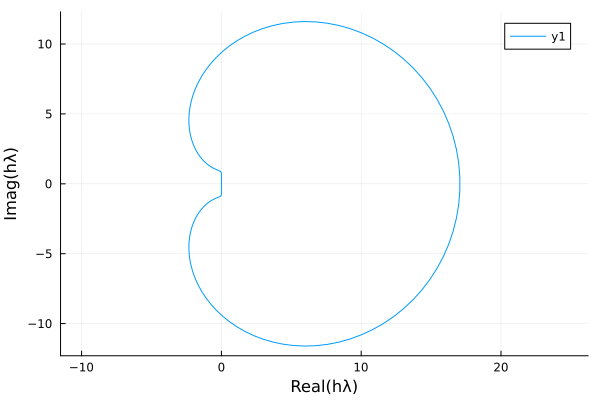

In [15]:
Z = (137 -300*z + 300*z^2 -200*z^3 +75*z^4 -12*z^5 ) / (60) |> subs(z => exp(1im * θ))
plot(real(Z), imag(Z), 0, 2π, xlabel="Real(hλ)", ylabel="Imag(hλ)", aspect_ratio=:equal)